# Overview 

The matrisome is a classification of components of the extracellular matrix. The matrisome can be divided into core matrisome proteins (glycoproteins, collagens, proteoglycans) and matrisome assocaited (affiliated, regulators and secreted factors. More information and the masterlist can be found at http://matrisome.org/. 

This notebook merges all three spatial transcriptomics datasets and corrects batch effects. Next, for each spot, the expression of matrisome divisions is selected. The number is clusters is found using ELBOW and mapped back to the original H&E image. Expression of the top 2 genes per cluster is visualized as a dot plot.

#Installations
Final cell restarts runtime - continue running from imports after 'Your session crashed for an unknown reason'. 

In [1]:
!pip install scanpy
!pip install anndata
!pip install scanorama
!pip install bbknn
!pip install leidenalg
#!pip uninstall xlrd
!pip install xlrd==1.2.0
!pip install leidenalg


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.3 MB/s 
     |████████████████████████████████| 11.2 MB 34.6 MB/s 
     |████████████████████████████████| 88 kB 7.7 MB/s 
     |████████████████████████████████| 96 kB 5.6 MB/s 
     |████████████████████████████████| 960 kB 56.2 MB/s 
     |████████████████████████████████| 1.1 MB 42.2 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=1688537dd33fe8dd33efd0f3bcd2baf88fab7bbb5fedf9ce47d6f5705bd780b0
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=a0aa97f5d6e5ba6ea9a4573d46de5ff3615e51c584b687418e61d06c6066a46e
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 647 kB 7.2 MB/s 
  Created wheel for annoy: filename=annoy-1.17.1-cp37-cp37m-linux_x86_64.whl size=395174 sha256=9e8ea93745d8bec63016923ec22bb3a03fbb1ff2ef94801d2390d1a519208a16
  Stored in directory: /root/.cache/pip/wheels/81/94/bf/92cb0e4fef8770fe9c6df0ba588fca30ab7c306b6048ae8a54
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11375 sha256=3f87c897e3bce588bd0dc26d6efa52fe9435288cd5d3e582d1f15b3e59d5636f
  Stored in directory: /root/.cache/pip/wheels/93/08/0c/1b9866c35c8d3f136d100dfe88036a32e0795437daca089f70
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26119 sha256=d5f2b735f0f5812675a67eaf3ff84ab2ff64fbeca5050bff08ba25611992e455
  Stored in directory: /root/.cache/pip/wheels/16/85/bd/10

In [ ]:
import os
os.kill(os.getpid(), 9)

# Imports

In [1]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scanorama
import os
from sklearn.cluster import KMeans
import textwrap
from yellowbrick.cluster import KElbowVisualizer
import os


# Helper functions

In [2]:
from numpy.lib.function_base import percentile


def download_data():
  ''' 
  Downloads:
  1. Human matrisome list 
  2. Three x10 Genomics prostate datasets - Normal, Invasive adenocarcinoma & acinar cellular carcinoma 
  ''' 

  # Matrisome masterlist 
  !wget http://matrisomeproject.mit.edu/static/media/uploads/Files/Human%20in%20silico%20matrisome/matrisome_hs_masterlist.xls

  # Download normal dataset, unzip & place in appropriate folder  
  os.mkdir('Normal')
  !wget https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Normal_Prostate/Visium_FFPE_Human_Normal_Prostate_filtered_feature_bc_matrix.h5
  !wget  https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Normal_Prostate/Visium_FFPE_Human_Normal_Prostate_spatial.tar.gz
  !tar -xzvf /content/Visium_FFPE_Human_Normal_Prostate_spatial.tar.gz
  os.replace('spatial', 'Normal/spatial')

  # Download invasive adenocarcinoma dataset 
  os.mkdir('IAC')
  !wget https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Prostate_Cancer/Visium_FFPE_Human_Prostate_Cancer_filtered_feature_bc_matrix.h5  
  !wget  https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Prostate_Cancer/Visium_FFPE_Human_Prostate_Cancer_spatial.tar.gz
  !tar -xzvf /content/Visium_FFPE_Human_Prostate_Cancer_spatial.tar.gz
  os.replace('spatial', 'IAC/spatial')
  

  # Download acinar cellular carcinoma dataset 
  os.mkdir('ACC')
  !wget https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Prostate_Acinar_Cell_Carcinoma/Visium_FFPE_Human_Prostate_Acinar_Cell_Carcinoma_filtered_feature_bc_matrix.h5
  !wget  https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Prostate_Acinar_Cell_Carcinoma/Visium_FFPE_Human_Prostate_Acinar_Cell_Carcinoma_spatial.tar.gz
  !tar -xzvf /content/Visium_FFPE_Human_Prostate_Acinar_Cell_Carcinoma_spatial.tar.gz
  os.replace('spatial', 'ACC/spatial')

  print('\n - - - - - - - - - - - ')
  print('Downloads complete')
  print(' - - - - - - - - - - - ')
  return 

def set_figure_dir(name): 
  name = name+'_figures'
  os.mkdir(name)
  sc.settings.figdir ='/content/' + name +'/'
  print('Image results will be saved in' , name, 'folder')
  return 

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
  

def plot_ranked_genes_per_cluster(adata, savename, c):
  # k means 
  X = adata.X.toarray()
  opt_k = find_k_elbow(X)
  km = KMeans(n_clusters=opt_k, random_state=0).fit(X) 
  adata.obs['kmeans'] = km.labels_.astype(str)

  # Plot ranks  
  sc.tl.rank_genes_groups(adata, 'kmeans', method='t-test')
  #sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, save = '_'+ savename)
  sc.pl.rank_genes_groups_dotplot(adata,n_genes=2, dendrogram = False, save = '_'+ savename, cmap = c)

  return 


def filter_matrisome(category): 
  '''
  Filters matrisome genes within ST dataset 
  '''
  # Download matrisome list
  #matrisome_list = pd.read_excel('/content/drive/MyDrive/Studies_Work/PhD_WT_IMC/Spatial transcriptomics/matrisome_hs_masterlist.xls')
  matrisome_list = pd.read_excel('/content/matrisome_hs_masterlist.xls')


  valid_categories = ['Collagens',
                      'ECM Glycoproteins',
                      'Proteoglycans',
                      'ECM-affiliated Proteins',
                      'ECM Regulators',
                      'Secreted Factors']

  if category not in valid_categories:
    print('Incorrect category, select from: ', valid_categories)
  coll_mask = matrisome_list['Category'] == category
  matrisome_genes = matrisome_list['Gene Symbol'][coll_mask].to_list()
  var_df = sc.get.var_df(adata)
  vis_genes = var_df.index.to_list()
  mat_cis_intersect = intersection(vis_genes, matrisome_genes)
  mask = [vg in mat_cis_intersect for vg in vis_genes]
  adata_category = adata[:, mask]
  return adata_category

def calculate_percentage_cluster(labels):
  percentages = [] 
  n_labels = np.unique(labels)
  for i in n_labels:
    mask = labels == i 
    sum_m = len(labels[mask].astype(float))
    p = sum_m / len(labels.astype(float))
    percentages.append(p)
  return np.round(percentages,2)



def merge_adatas(files_locations, dataset_names): 
  adata_dict = {}

  for i in range(len(dataset_names)):
    adata_dict[dataset_names[i]] = load_data(files_locations[i][0], files_locations[i][1])
    adata_dict[dataset_names[i]].var_names_make_unique()

  batch_id = ['Normal', 'Invasive adenocarcinoma', 'Acinar cellulcar carcinoma']

  adata = adata_dict['Norm'].concatenate(
      (adata_dict['IAC'], adata_dict['ACC']),
      batch_key='batch_id',
      uns_merge="unique",
      batch_categories=batch_id
  )

  return adata, adata_dict


def map_kms_to_hires_image(adata): 
  km_labels = np.array(adata.obs['kmeans'].values)
  
  norm_len = adata_dict['Norm'].shape[0]
  norm_km_y = km_labels[:norm_len]

  IAC_len = adata_dict['IAC'].shape[0]
  IAC_km_y = km_labels[norm_len:(norm_len+IAC_len)]

  ACC_len = adata_dict['ACC'].shape[0]
  ACC_km_y = km_labels[(norm_len+IAC_len):]

  km_ys = [norm_km_y, IAC_km_y, ACC_km_y]

  for i in range(len(dataset_names)): 
    adata_dict[dataset_names[i]].obs['kmeans'] = km_ys[i]
  return adata_dict

def plot_hires_km(adata_dict, palette_key,savename):
  keys = ['Norm', 'IAC', 'ACC']
  for i,k in enumerate(keys): 
    fig, ax = plt.subplots(1,2)
    sc.pl.spatial(adata_dict[k], ax=ax[0], show=False)
    sc.pl.spatial(adata_dict[k], img_key="hires", color="kmeans",  palette =palette_key, ax=ax[1],show=True, title=None, save='_' + savename+'_'+k+'.png') 
    sc.pl.spatial(adata_dict[k], img_key="hires", color="kmeans",  palette =palette_key, ax=ax[1],show=False)
    plt.show()
  return 

def calc_all_percentages():
    keys = ['Norm', 'IAC', 'ACC']
    all_p = []
    for k in keys: 
      p = calculate_percentage_cluster(adata_dict[k].obs['kmeans'])
      all_p.append(p)
    df = pd.Dataframe((all_p), index=keys)
    return df.transpose()


def calc_all_percentages(adata_dict):
    keys = ['Norm', 'IAC', 'ACC']
    all_p = []
    for k in keys: 
      p = calculate_percentage_cluster(adata_dict[k].obs['kmeans'])
      all_p.append(p)
      print(k)
      print(all_p)
      print('----')
    df = pd.DataFrame((all_p), index=keys)
    return df

  
def find_k_elbow(X):
  model = KElbowVisualizer(KMeans(), k=10)
  model.fit(X)
  model.show()
  return model.elbow_value_

def load_data(pf, cf):
  adata = sc.read_visium(pf, genome=None, count_file=cf, library_id=None, load_images=True,
                           source_image_path=None)
  return adata

def count_labels(adata):
  '''
  Counts malignant and cluster labels 
  '''

  # Load labels from classifier 
  maligancy_labels = adata.obs['malignancy_labels'].values

  # Cluster labels 
  #adata_iac = adata.obs[adata.obs['batch_id'] == 'Invasive adenocarcinoma']
  labels = adata.obs['kmeans'].values

  # Contingency table with collagen clusters relative to predicted malignat spots in IAC
  malig_table = pd.crosstab(maligancy_labels, labels)
  #malig_table.columns = ['Col cluster 0', ' Col cluster 1', 'Col cluster 2', 'Col cluster 3']
  malig_table.index = ['Non-maligant', 'Malignant']
  return  malig_table

In [3]:
# Uncomment to set images to higher resolution 
#sc.set_figure_params(dpi=300, dpi_save=300, fontsize=10)

# Download data

Downloads human matrisome masterlist and three prostate spatial transcriptomics datasets -  a normal, invasive adenocarcinoma  and acinar cellular carcinoma. 

For more information about the spatial transcriptomic datasets or matrisome list, please click the links below: 

[Human matrisome](http://matrisome.org/)

[Normal](https://www.10xgenomics.com/resources/datasets/normal-human-prostate-ffpe-1-standard-1-3-0) 

[Invasive adenocarcinoma](https://www.10xgenomics.com/resources/datasets/human-prostate-cancer-adenocarcinoma-with-invasive-carcinoma-ffpe-1-standard-1-3-0) 

[Acinar cellular carcinoma ](https://www.10xgenomics.com/resources/datasets/human-prostate-cancer-acinar-cell-carcinoma-ffpe-1-standard)



In [4]:
download_data()

--2022-10-13 14:45:40--  http://matrisomeproject.mit.edu/static/media/uploads/Files/Human%20in%20silico%20matrisome/matrisome_hs_masterlist.xls
Resolving matrisomeproject.mit.edu (matrisomeproject.mit.edu)... 18.18.159.13
Connecting to matrisomeproject.mit.edu (matrisomeproject.mit.edu)|18.18.159.13|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 378880 (370K) [application/vnd.ms-excel]
Saving to: ‘matrisome_hs_masterlist.xls’

matrisome_hs_master 100%[===================>] 370.00K   510KB/s    in 0.7s    

2022-10-13 14:45:41 (510 KB/s) - ‘matrisome_hs_masterlist.xls’ saved [378880/378880]

--2022-10-13 14:45:41--  https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Normal_Prostate/Visium_FFPE_Human_Normal_Prostate_filtered_feature_bc_matrix.h5
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP requ

# Preprocessing

## Load and merge datasets

In [5]:
# Set paths to spatial folder + matrix

# Normal paths 
pf_norm = '/content/Normal'
cf_nom = '/content/Visium_FFPE_Human_Normal_Prostate_filtered_feature_bc_matrix.h5'

# Invasive adenocarcinoma paths 
pf_iac = '/content/IAC'
cf_iac = '/content/Visium_FFPE_Human_Prostate_Cancer_filtered_feature_bc_matrix.h5'

pf_acc = '/content/ACC'
cf_acc = '/content/Visium_FFPE_Human_Prostate_Acinar_Cell_Carcinoma_filtered_feature_bc_matrix.h5'

files_locations = [[pf_norm, cf_nom], [pf_iac, cf_iac], [pf_acc, cf_acc]]


Load annotated data from 4 prostate spatial transcriptomics datasets 

In [6]:
dataset_names = ['Norm', 'IAC', 'ACC']
adata, adata_dict = merge_adatas(files_locations, dataset_names)

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


## Quality control & Normalization

In [7]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

adata = adata[adata.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

# Normalize data
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

#cells after MT filter: 9957


/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


## Visualizing batch effect

         Falling back to preprocessing with `sc.pp.pca` and default params.


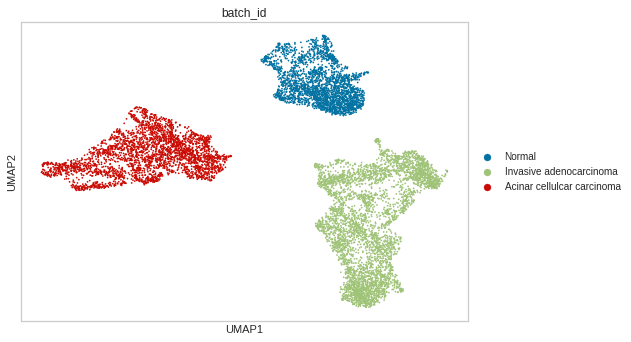

In [8]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch_id'],save= 'batch_effect.png')

## Batch control - bbknn

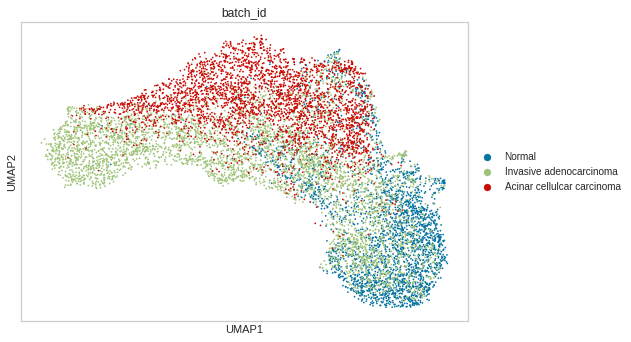

In [10]:
sc.external.pp.bbknn(adata, batch_key='batch_id') 
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch_id'], save='_corrected_be.png')

# Collagen 
Image results saved in 'Collagens_figures' folder


In [11]:
set_figure_dir('Collagens')

Image results will be saved in Collagens_figures folder


In [12]:
adata_collagens = filter_matrisome('Collagens')

In [13]:
adata_collagens

View of AnnData object with n_obs × n_vars = 9957 × 43
    obs: 'in_tissue', 'array_row', 'array_col', 'batch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg', 'neighbors', 'umap', 'batch_id_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

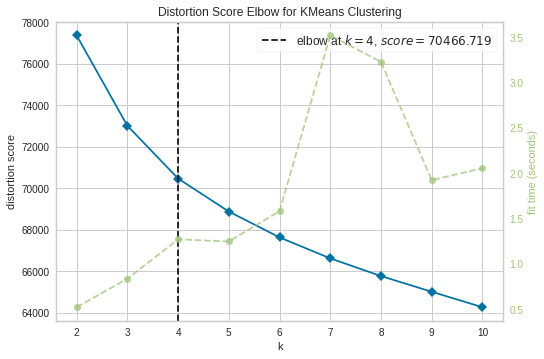

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


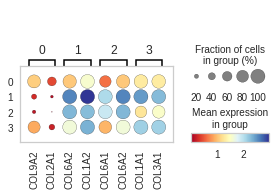

In [14]:
plot_ranked_genes_per_cluster(adata_collagens, 'collagen.png', 'RdYlBu')

In [15]:
adata_dict = map_kms_to_hires_image(adata_collagens)

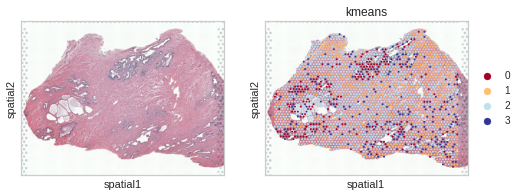

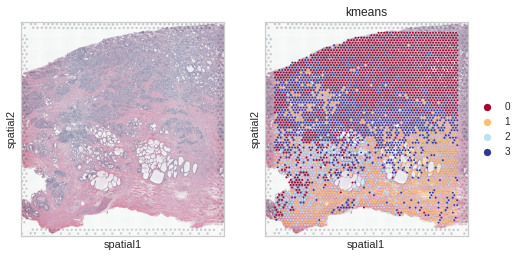

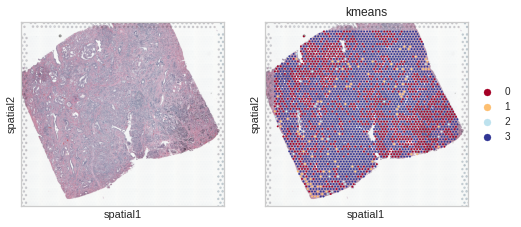

In [16]:
plot_hires_km(adata_dict, 'RdYlBu', 'collagens')

In [17]:
# Proportions per dataset, manually created into stacked barchart 
p_df = calc_all_percentages(adata_dict)
p_df.to_excel('coll_percentages.xlsx')

Norm
[array([0.09, 0.31, 0.51, 0.09])]
----
IAC
[array([0.09, 0.31, 0.51, 0.09]), array([0.34, 0.27, 0.11, 0.28])]
----
ACC
[array([0.09, 0.31, 0.51, 0.09]), array([0.34, 0.27, 0.11, 0.28]), array([0.36, 0.03, 0.01, 0.59])]
----


In [18]:
# Save km labels for later analysis
adata_dict['Norm'].obs.to_excel('norm_km_labels.xlsx')
adata_dict['IAC'].obs.to_excel('iac_km_labels.xlsx')
adata_dict['ACC'].obs.to_excel('aac_km_labels.xlsx')


# Glycoproteins  
Image results will be saved in 'Glycoproteins_figures' folder

In [19]:
set_figure_dir('Glycoproteins')

Image results will be saved in Glycoproteins_figures folder


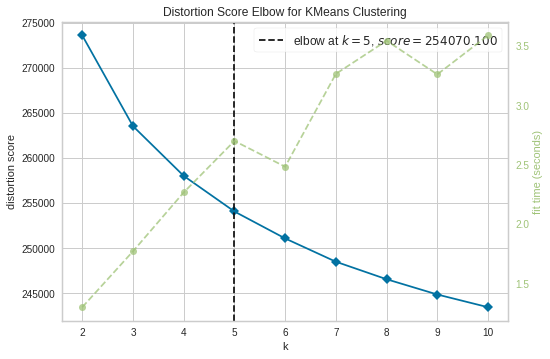

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


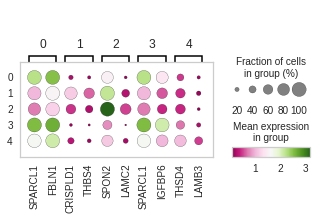

In [20]:
adata_gp = filter_matrisome('ECM Glycoproteins')
plot_ranked_genes_per_cluster(adata_gp, '_GP.png',  'PiYG')

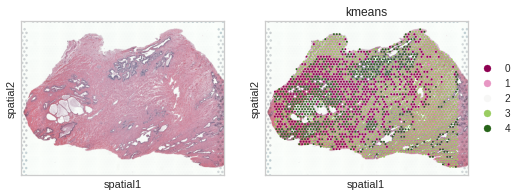

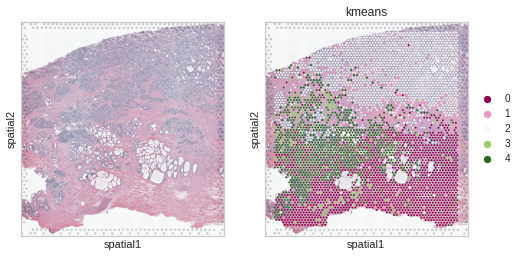

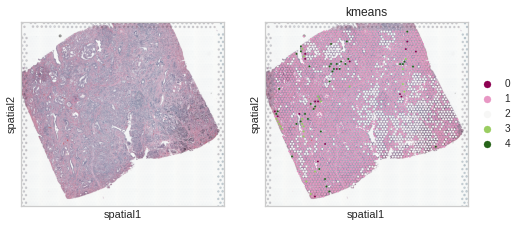

In [21]:
adata_dict = map_kms_to_hires_image(adata_gp)
plot_hires_km(adata_dict, "PiYG", 'glycoproteins')

In [22]:
p_df_gp = calc_all_percentages(adata_dict)
p_df_gp.to_excel('percentage_k_glyp.xlsx')

Norm
[array([0.22, 0.  , 0.01, 0.49, 0.27])]
----
IAC
[array([0.22, 0.  , 0.01, 0.49, 0.27]), array([0.28, 0.12, 0.33, 0.03, 0.23])]
----
ACC
[array([0.22, 0.  , 0.01, 0.49, 0.27]), array([0.28, 0.12, 0.33, 0.03, 0.23]), array([0.01, 0.72, 0.25, 0.01, 0.01])]
----


In [23]:
adata_dict['Norm'].obs.to_excel('gp_norm_km_labels.xlsx')
adata_dict['IAC'].obs.to_excel('gp_iac_km_labels.xlsx')
adata_dict['ACC'].obs.to_excel('gp_aac_km_labels.xlsx')


# Proteoglycans 

Image results will be saved in Proteoglycans_figures folder


In [24]:
set_figure_dir('Proteoglycans')

Image results will be saved in Proteoglycans_figures folder


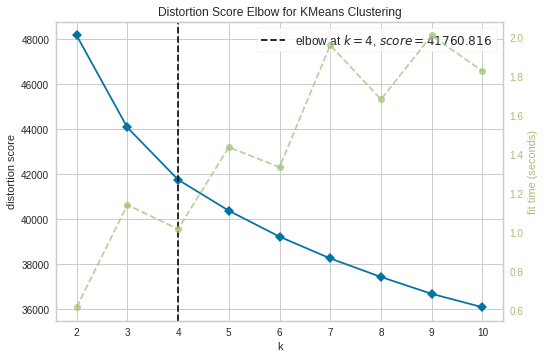

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


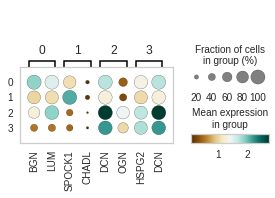

In [25]:
adata_pg = filter_matrisome('Proteoglycans')
plot_ranked_genes_per_cluster(adata_pg, 'PG_dotplot.png', 'BrBG')

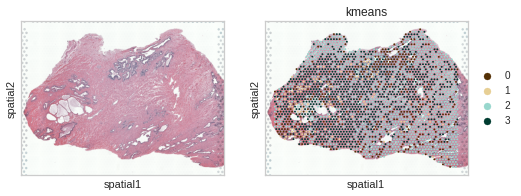

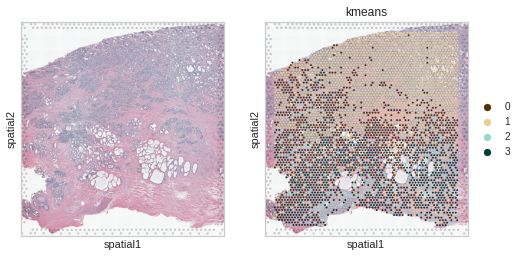

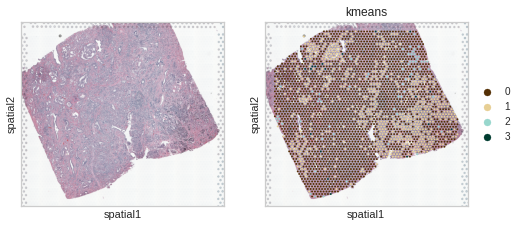

In [26]:
adata_dict = map_kms_to_hires_image(adata_pg)
plot_hires_km(adata_dict, 'BrBG', 'proteoglycans')

In [27]:
p_df_pg = calc_all_percentages(adata_dict)
p_df_pg.to_excel('percentage_k_pg.xlsx')

Norm
[array([0.14, 0.05, 0.41, 0.4 ])]
----
IAC
[array([0.14, 0.05, 0.41, 0.4 ]), array([0.25, 0.45, 0.1 , 0.19])]
----
ACC
[array([0.14, 0.05, 0.41, 0.4 ]), array([0.25, 0.45, 0.1 , 0.19]), array([0.74, 0.23, 0.02, 0.01])]
----


In [28]:
adata_dict['Norm'].obs.to_excel('pg_norm_km_labels.xlsx')
adata_dict['IAC'].obs.to_excel('pg_iac_km_labels.xlsx')
adata_dict['ACC'].obs.to_excel('pg_aac_km_labels.xlsx')

# Regulators

Image results saved in Regulators_figures folder


In [29]:
set_figure_dir('Regulators')

Image results will be saved in Regulators_figures folder


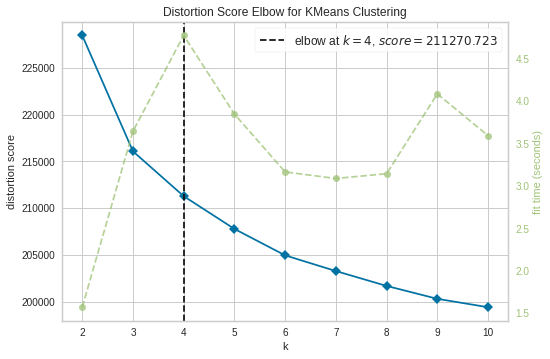

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


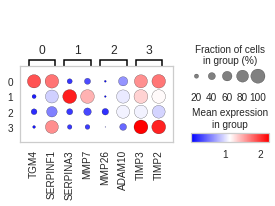

In [30]:
adata_rg = filter_matrisome('ECM Regulators')
plot_ranked_genes_per_cluster(adata_rg, 'dot_Reg.png', 'bwr')

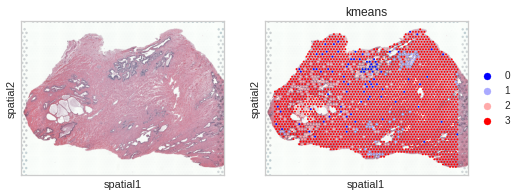

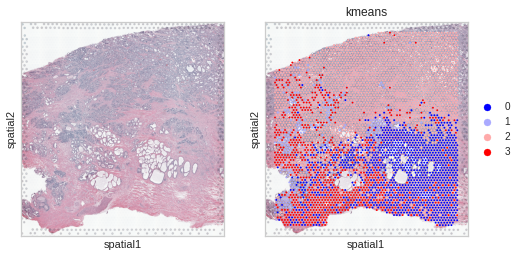

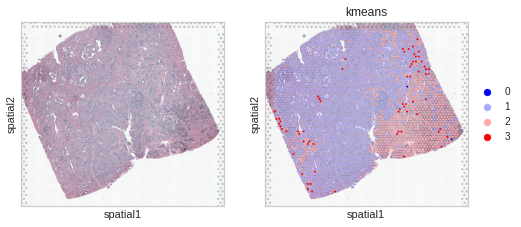

In [31]:
adata_dict = map_kms_to_hires_image(adata_rg)
plot_hires_km(adata_dict, 'bwr', 'regulators')


In [32]:
adata_dict['Norm'].obs.to_excel('reg_norm_km_labels.xlsx')
adata_dict['IAC'].obs.to_excel('reg_iac_km_labels.xlsx')
adata_dict['ACC'].obs.to_excel('reg_aac_km_labels.xlsx')


In [33]:
p_df = calc_all_percentages(adata_dict)
p_df.to_excel('regs_percentages.xlsx')

Norm
[array([0.04, 0.03, 0.1 , 0.83])]
----
IAC
[array([0.04, 0.03, 0.1 , 0.83]), array([0.26, 0.05, 0.49, 0.19])]
----
ACC
[array([0.04, 0.03, 0.1 , 0.83]), array([0.26, 0.05, 0.49, 0.19]), array([0.  , 0.74, 0.23, 0.02])]
----
